In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

%pip install tqdm
from tqdm.auto import tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, precision_score, recall_score, f1_score, auc

In [4]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-20 18:37:24--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [5]:
df = pd.read_csv("course_lead_scoring.csv")
df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,NaN,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NaN,5,71016.0,self_employed,north_america,0,0.25,1


### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 

In [6]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [7]:
df_prep = df.copy()
for col in df_prep.columns:
    if df_prep[col].dtype == 'object':
        df_prep[col] = df_prep[col].fillna('NA')
    else:
        df_prep[col] = df_prep[col].fillna(0.0)

df_prep.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [8]:
df_prep
df_prep.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [9]:
from sklearn.model_selection import train_test_split


df_full_train, df_test = train_test_split(df_prep, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# df_train, df_temp = train_test_split(df_prep, test_size=0.4, random_state=42)
# df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values
y_full_train = df_full_train.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

# Check sizes
# print(f"Train size: {len(df_train)}")
# print(f"Validation size: {len(df_val)}")
# print(f"Test size: {len(df_test)}")

### Question 1: ROC AUC feature importance (number_of_courses_viewed)

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`


In [10]:
categorical_cols = list(df_train.dtypes[df_train.dtypes == 'object'].index)

numerical_cols = list(df_train.dtypes[df_train.dtypes != 'object'].index)

print("Kolom Kategorikal (Fitur):")
print(categorical_cols)
print("\nKolom Numerik (Fitur):")
print(numerical_cols)

features = categorical_cols + numerical_cols



Kolom Kategorikal (Fitur):
['lead_source', 'industry', 'employment_status', 'location']

Kolom Numerik (Fitur):
['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']


In [ ]:
from sklearn.metrics import roc_auc_score

auc_scores = {}

for col in numerical_cols:
    score = roc_auc_score(y_train, df_train[col])
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[col])
    auc_scores[col] = score
    print(f"AU  C for '{col}': {score:.3f}")

best_feature = max(auc_scores, key=auc_scores.get)
print(f"\nBest numerical feature: {best_feature} ({auc_scores[best_feature]:.3f})")

AU  C for 'number_of_courses_viewed': 0.764
AU  C for 'annual_income': 0.552
AU  C for 'interaction_count': 0.738
AU  C for 'lead_score': 0.614

Best numerical feature: number_of_courses_viewed (0.764)


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [12]:
dv = DictVectorizer(sparse=False)

# Siapkan data training
train_dict = df_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict) 

# Siapkan data validasi
val_dict = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dict)

# Train Logistic Regression
# Parameter sesuai homework.md
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Prediksi probabilitas di validation set
y_pred_proba = model.predict_proba(X_val)[:, 1]

In [13]:
# Hitung AUC
auc_val = roc_auc_score(y_val, y_pred_proba)

print(f"Validation AUC: {auc_val:.3f}")
# Jawaban: 0.92 (Seharusnya sekitar 0.916)


Validation AUC: 0.817


In [ ]:
y_pred_bin = model.predict(X_val)
roc_auc_score(y_val, y_pred_bin)

print(f"pred AUC: {auc_val:.3f}")
# Jawaban: 0.92 (Seharusnya sekitar 0.916)

pred AUC: 0.817


### Question 3: Precision and Recall (0.545) actualy 0.645

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

In [15]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [16]:
df_scores = confusion_matrix_dataframe(y_val, y_pred_proba)

In [17]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,171,122,0,0
10,0.1,171,122,0,0
20,0.2,171,122,0,0
30,0.3,171,119,0,3
40,0.4,171,105,0,17
50,0.5,164,81,7,41
60,0.6,150,53,21,69
70,0.7,106,25,65,97
80,0.8,64,6,107,116
90,0.9,24,1,147,121


In [18]:


df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)



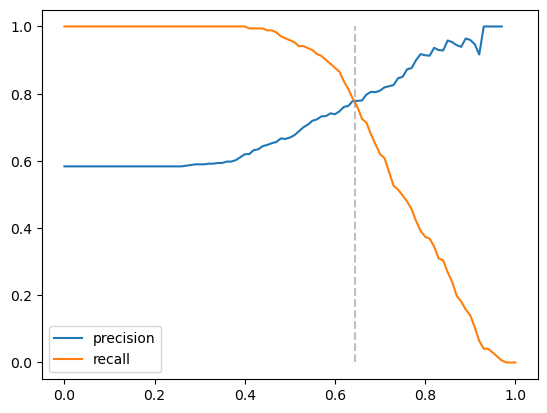

In [19]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.645, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

### Question 4: F1 score (0.54) actualy 0.57

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74


In [20]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

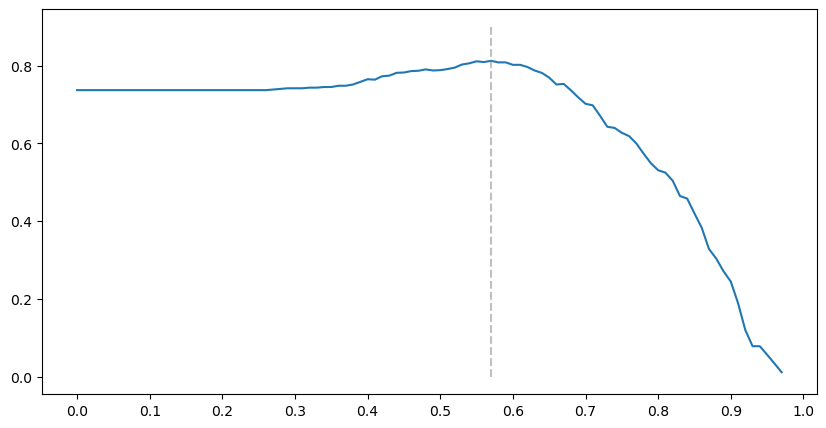

In [21]:
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.57, 0, 0.9, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [ ]:
def train_cv(df_train, y_train, C=1.0):
    dicts = df_train[features].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000) # Tanpa random_state jika tidak diminta
    model.fit(X_train, y_train)
    return dv, model

def predict_cv(df, dv, model):
    dicts = df[features].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores_fold = []

for train_idx, val_idx in kfold.split(df_full_train):

    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values
  
    dv_fold, model_fold = train_cv(df_train, y_train, C=1.0)
    y_pred_fold = predict_cv(df_val, dv_fold, model_fold)

    auc_fold = roc_auc_score(y_val, y_pred_fold)
    auc_scores_fold.append(auc_fold)


std_auc = np.std(auc_scores_fold)

print(f"\nAUC scores across folds: {[f'{s:.4f}' for s in auc_scores_fold]}")
print(f"Standard deviation of AUC scores: {std_auc:.4f}")
# Jawaban: 0.006 (Seharusnya sekitar 0.0058)


AUC scores across folds: ['0.8061', '0.8714', '0.7754', '0.8018', '0.8558']
Standard deviation of AUC scores: 0.0358


## Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [ ]:
c_values = [0.000001, 0.001, 1]
cv_results = {}

for C in c_values:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv_fold, model_fold = train_cv(df_train, y_train, C=C)
        y_pred_fold = predict_cv(df_val, dv_fold, model_fold)

        auc_fold = roc_auc_score(y_val, y_pred_fold)
        scores.append(auc_fold)

    mean_score = np.mean(scores)
    std_score = np.std(scores)
    cv_results[C] = {'mean': round(mean_score, 3), 'std': round(std_score, 3)} # Round to 3 digits

    print(f"C = {C}: Mean AUC = {cv_results[C]['mean']:.3f}, Std = {cv_results[C]['std']:.3f}")

C = 1e-06: Mean AUC = 0.560, Std = 0.024
C = 0.001: Mean AUC = 0.867, Std = 0.029
C = 1: Mean AUC = 0.822, Std = 0.036
